# Sentiment Analysis of Earnings Call Transcripts (JPM & HSBC)

**Purpose:**  
Apply sentiment analysis to Q&A sections of JPMorgan and HSBC quarterly earnings calls (2023–2025) using two transformer models:  
- `mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis`
- `cardiffnlp/twitter-roberta-base-sentiment`

**Inputs:**
- Processed CSVs with transcripts:
  - `/data/processed/jpm/all_jpm_2023_2025.csv`
  - `/data/processed/hsbc/all_hsbc_earnings_data.csv`

**Outputs:**
- DataFrames with sentiment predictions
- `.csv` files with added sentiment labels and scores

In [6]:
# --- 1.1 Install required packages ---
!pip -q install pandas numpy transformers torch

# --- 1.2 Clone GitHub repository ---
!git clone https://github.com/JSA10/cam_ds_ep_FinSight.git

# --- 1.3 Import libraries ---
import pandas as pd
import numpy as np
import random
import torch
from pathlib import Path

# --- 1.4 Set random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- 1.5 Set project paths ---
project_root = Path("/content/cam_ds_ep_FinSight")
data_dir = project_root / "data" / "processed"
jpm_path = data_dir / "jpm" / "all_jpm_2023_2025.csv"
hsbc_path = data_dir / "hsbc" / "all_hsbc_earnings_data.csv"

# --- 1.6 Confirm everything is ready ---
print("📁 JPM path:", jpm_path)
print("📁 HSBC path:", hsbc_path)
print("✅ Environment setup complete.")

fatal: destination path 'cam_ds_ep_FinSight' already exists and is not an empty directory.
📁 JPM path: /content/cam_ds_ep_FinSight/data/processed/jpm/all_jpm_2023_2025.csv
📁 HSBC path: /content/cam_ds_ep_FinSight/data/processed/hsbc/all_hsbc_earnings_data.csv
✅ Environment setup complete.


In [7]:
# --- 2. Import data ---
# JPMorgan: earnings call transcripts 2023–2025
jpm_df = pd.read_csv(jpm_path)
print(f"✅ Loaded JPM data: {jpm_df.shape[0]:,} rows × {jpm_df.shape[1]} columns")

# HSBC: earnings call transcripts 2023–2025
hsbc_df = pd.read_csv(hsbc_path)
print(f"✅ Loaded HSBC data: {hsbc_df.shape[0]:,} rows × {hsbc_df.shape[1]} columns")

# --- Preview the JPM dataframe ---
jpm_df.head()

✅ Loaded JPM data: 1,411 rows × 11 columns
✅ Loaded HSBC data: 376 rows × 11 columns


,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
1,qa,NaN,NaN,Steven Chubak,analyst,Wolfe Research LLC,"Hey, good morning.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
2,qa,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, Steve.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


## 3. Preprocessing

In this step, we will filter the data to include only banker answers (executives or management),
as these are the focus for sentiment analysis.

We will remove:
- questions from analysts,
- pleasantries (e.g., "Good morning"),
- any presentation sections.

We'll keep only proper answers from management in the Q&A section.

#### Why exclude analyst questions?

We aim to analyse the emotional tone of executive answers. Including external analysts' questions would dilute the sentiment signal and introduce noise. Therefore, we filter out all rows where role = "analyst".

In [11]:
# --- 3.1 Filter only Q&A section ---
jpm_df = jpm_df[jpm_df['section'] == 'qa']
hsbc_df = hsbc_df[hsbc_df['section'] == 'qa']

# --- 3.2 Remove pleasantries ---
jpm_df = jpm_df[~jpm_df['is_pleasantry']]
hsbc_df = hsbc_df[~hsbc_df['is_pleasantry']]
# --- 3.3 Inspect unique roles ---
print("JPM roles:\n", jpm_df['role'].dropna().unique())
print("\nHSBC roles:\n", hsbc_df['role'].dropna().unique())

JPM roles:
 ['analyst' 'Chairman & Chief Executive Officer' 'Chief Financial Officer'
 'And then some. Theres a lot of value added.' 'Okay'
 'But the percent who are digital only is much lower than that.'
 'Is that for First Republic too' "We're fundamentally" 'Thanks'
 'Almost no chance.']

HSBC roles:
 ['Analyst' 'management']


#### Define valid management roles and filter
Based on the list above, we now filter only valid management answers.

In [12]:
# --- 3.4 Define valid roles based on inspection ---
valid_jpm_roles = [
    'Chairman & Chief Executive Officer',
    'Chief Financial Officer'
]

valid_hsbc_roles = ['management']  # HSBC transcripts use only "management" for answers

# --- 3.5 Filter only banker (i.e. management) answers ---
jpm_answers_df = jpm_df[jpm_df['role'].isin(valid_jpm_roles)].copy()
hsbc_answers_df = hsbc_df[hsbc_df['role'].isin(valid_hsbc_roles)].copy()

# --- 3.6 Reset index ---
jpm_answers_df.reset_index(drop=True, inplace=True)
hsbc_answers_df.reset_index(drop=True, inplace=True)

print(f"✅ JPM banker answers: {len(jpm_answers_df):,}")
print(f"✅ HSBC banker answers: {len(hsbc_answers_df):,}")

✅ JPM banker answers: 697
✅ HSBC banker answers: 146


## 4. Sentiment Analysis with DistilRoBERTa model

We’ll now apply the **DistilRoBERTa model fine-tuned on financial news** - *mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis* - to the answers of management (bankers) from JPM and HSBC.

#### Install & import required modules

In [13]:
# --- 4.1 Install Hugging Face Transformers (if not already installed) ---
!pip -q install transformers

# --- 4.2 Import sentiment pipeline ---
from transformers import pipeline

#### Load sentiment model

In [14]:
# --- 4.3 Load the sentiment pipeline using mrm8488/distilroberta ---
sentiment_pipeline_financial = pipeline(
    task="sentiment-analysis",
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
)

print("✅ Model loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


✅ Model loaded.


#### Define helper function to apply sentiment model

In [15]:
# --- 4.4 Function to apply sentiment model to a list of texts ---
def apply_sentiment_analysis(texts, pipeline, label_map=None):
    results = pipeline(texts, truncation=True)
    sentiments = []
    scores = []

    for res in results:
        label = res["label"]
        if label_map:
            label = label_map.get(label, label)
        sentiments.append(label)
        scores.append(res["score"])

    return sentiments, scores

#### Run DistilRoBERTa sentiment analysis on JPM and HSBC answers

In [16]:
# --- 4.5 Extract content to analyse ---
jpm_texts = jpm_answers_df["content"].tolist()
hsbc_texts = hsbc_answers_df["content"].tolist()

# --- 4.6 Apply model to both sets of answers ---
jpm_sentiments, jpm_scores = apply_sentiment_analysis(jpm_texts, sentiment_pipeline_financial)
hsbc_sentiments, hsbc_scores = apply_sentiment_analysis(hsbc_texts, sentiment_pipeline_financial)

# --- 4.7 Add results back to DataFrames ---
jpm_answers_df["sentiment_finbert_label"] = jpm_sentiments
jpm_answers_df["sentiment_finbert_score"] = jpm_scores

hsbc_answers_df["sentiment_finbert_label"] = hsbc_sentiments
hsbc_answers_df["sentiment_finbert_score"] = hsbc_scores

print("✅ Sentiment analysis complete.")

✅ Sentiment analysis complete.


### Validate DistiRoBERTa model Sentiment Outputs (Quality Check)

### Check sentiment label distribution

In [17]:
# --- 4.5.1 Check overall distribution of predicted labels ---
print("📊 JPM Sentiment Distribution:")
print(jpm_answers_df["sentiment_finbert_label"].value_counts())

print("\n📊 HSBC Sentiment Distribution:")
print(hsbc_answers_df["sentiment_finbert_label"].value_counts())

📊 JPM Sentiment Distribution:
sentiment_finbert_label
neutral     424
positive    194
negative     79
Name: count, dtype: int64

📊 HSBC Sentiment Distribution:
sentiment_finbert_label
positive    86
neutral     52
negative     8
Name: count, dtype: int64


### View examples for each sentiment label

In [18]:
# --- 4.5.2 View sample sentences per label ---
for label in jpm_answers_df["sentiment_finbert_label"].unique():
    print(f"\n🔹 Example JPM sentence for sentiment: {label}")
    example = jpm_answers_df[jpm_answers_df["sentiment_finbert_label"] == label].iloc[0]
    print(example["content"])
    print(f"→ Score: {example['sentiment_finbert_score']:.2f}")


🔹 Example JPM sentence for sentiment: neutral
Well, I think you were already kind of complete with answering your own question there. Look, we're hoping that everyone just takes a deep breath and looks at what happened and the breadth and depth of regulations already in place. Obviously, when something happens like this, you should adjust, think about it. So I think down the road there may be some limitations on held-to-maturity, maybe more TLAC for certain type-size banks, and more scrutiny on interest rate exposure, and stuff like that. But it doesn't have to be a revamp of the whole system, just recalibrating things the right way. And I think it should be done knowing what you want the outcome to be. The outcome you should want is very strong community and regional banks. And certain actions are taken which are drastic – it could actually make them weaker. So, that's all it is. We do expect higher capital from Basel IV, effectively and, obviously there's going to be an FDIC assessm

In [20]:
# --- 4.5.3 View low-confidence predictions for manual review ---
print("🔻 Low-confidence JPM predictions:")
print(jpm_answers_df.sort_values("sentiment_finbert_score").head(5)[["content", "sentiment_finbert_label", "sentiment_finbert_score"]])


🔻 Low-confidence JPM predictions:
                                               content  \
642  Yeah. Actually, John, this quarter, that's all...   
307  Remember, we can do a lot of things to change ...   
258  I was just going to say we're not going to do ...   
694  I was just going to say we're not going to do ...   
409  Yeah. So I would caution you from drawing too ...   

    sentiment_finbert_label  sentiment_finbert_score  
642                negative                 0.507658  
307                 neutral                 0.514653  
258                 neutral                 0.524082  
694                 neutral                 0.524082  
409                negative                 0.533763  


In [21]:
print("\n🔻 Low-confidence HSBC predictions:")
print(hsbc_answers_df.sort_values("sentiment_finbert_score").head(5)[["content", "sentiment_finbert_label", "sentiment_finbert_score"]])


🔻 Low-confidence HSBC predictions:
                                               content  \
115  Thanks, Kun peng.  So we’re not going to get i...   
45   I’ll answer your second question.  You should ...   
91   So the banking NII sensitivity to a 10% change...   
35   I think you’ve overread it, because what we sa...   
120  Thanks, Jason .  So firstly, we manage costs t...   

    sentiment_finbert_label  sentiment_finbert_score  
115                negative                 0.483724  
45                 positive                 0.511553  
91                  neutral                 0.625744  
35                  neutral                 0.631642  
120                positive                 0.653630  


### Check low-confidence predictions

In [23]:
# Filter low-confidence predictions (< 0.6 score)
low_conf_jpm_df = jpm_answers_df[jpm_answers_df['sentiment_finbert_score'] < 0.6]
low_conf_hsbc_df = hsbc_answers_df[hsbc_answers_df['sentiment_finbert_score'] < 0.6]

print(f"🔻 Low-confidence JPM predictions: {len(low_conf_jpm_df)}")
print(f"🔻 Low-confidence HSBC predictions: {len(low_conf_hsbc_df)}")

🔻 Low-confidence JPM predictions: 8
🔻 Low-confidence HSBC predictions: 2



## 5. Run sentiment analysis (CardiffNLP Twitter-RoBERTa)

We'll now apply a second model — `cardiffnlp/twitter-roberta-base-sentiment`,
which is trained on tweets but often used as a general-purpose sentiment model.  
This allows us to compare its performance against FinBERT.

We'll:
- Load the model and tokenizer
- Apply it to both JPM and HSBC responses
- Store label and confidence score

### Install and load the model and tokenizer

In [26]:
# --- 5.1 Load CardiffNLP model and tokenizer ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

cardiff_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
cardiff_tokenizer = AutoTokenizer.from_pretrained(cardiff_model_name)
cardiff_model = AutoModelForSequenceClassification.from_pretrained(cardiff_model_name)

# Label mapping used by this model
cardiff_labels = ['negative', 'neutral', 'positive']

print("✅ CardiffNLP model loaded.")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

✅ CardiffNLP model loaded.


### Define prediction function to apply sentiment model

In [29]:
# --- 4.2 Define prediction function (with truncation fix) ---
def predict_cardiff_sentiment(text, model, tokenizer):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512  # RoBERTa supports up to 512 tokens
    )
    with torch.no_grad():
        outputs = model(**inputs)
    scores = F.softmax(outputs.logits, dim=1)[0]
    label_id = scores.argmax().item()
    label = cardiff_labels[label_id]
    confidence = scores[label_id].item()
    return label, confidence

### Run Twitter-RoBERTa sentiment analysis on JPM and HSBC answers

In [30]:
# --- 5.3 Apply model to banker answers ---

# JPM
jpm_cardiff_preds = jpm_answers_df['content'].apply(
    lambda x: predict_cardiff_sentiment(x, cardiff_model, cardiff_tokenizer)
)
jpm_answers_df['sentiment_cardiff_label'] = jpm_cardiff_preds.apply(lambda x: x[0])
jpm_answers_df['sentiment_cardiff_score'] = jpm_cardiff_preds.apply(lambda x: x[1])

# HSBC
hsbc_cardiff_preds = hsbc_answers_df['content'].apply(
    lambda x: predict_cardiff_sentiment(x, cardiff_model, cardiff_tokenizer)
)
hsbc_answers_df['sentiment_cardiff_label'] = hsbc_cardiff_preds.apply(lambda x: x[0])
hsbc_answers_df['sentiment_cardiff_score'] = hsbc_cardiff_preds.apply(lambda x: x[1])

print("✅ Cardiff sentiment prediction complete.")

✅ Cardiff sentiment prediction complete.


### Preview CardiffNLP sentiment results
We'll preview some results to assess the model output.

- Distribution of predicted labels
- Example of each sentiment
- Any low-confidence predictions

In [32]:
# Label distribution
print("📊 JPM Cardiff Sentiment Distribution:")
print(jpm_answers_df['sentiment_cardiff_label'].value_counts())

print("\n📊 HSBC Cardiff Sentiment Distribution:")
print(hsbc_answers_df['sentiment_cardiff_label'].value_counts())

📊 JPM Cardiff Sentiment Distribution:
sentiment_cardiff_label
neutral     473
positive    167
negative     57
Name: count, dtype: int64

📊 HSBC Cardiff Sentiment Distribution:
sentiment_cardiff_label
neutral     103
positive     43
Name: count, dtype: int64


In [33]:
# Show example for each sentiment
for label in ['positive', 'neutral', 'negative']:
    print(f"\n🔹 Example JPM {label} response:")
    example = jpm_answers_df[jpm_answers_df['sentiment_cardiff_label'] == label].iloc[0]
    print(example['content'])
    print("→ Score:", round(example['sentiment_cardiff_score'], 2))


🔹 Example JPM positive response:
Yeah, sure. So let me just summarize the drivers of the change in the outlook. So the primary driver really is lower deposit rate paid expectations across both consumer and wholesale, which, as you mentioned, is driven by a couple factors. So, the change in the rate environment, with cuts coming sooner in the outlook, all else equal, does take some pressure off the reprice. And as you said, we're getting a lot of positive feedback from the field on our product offerings. The short-term CD, in particular, is really getting a lot of positive feedback from our folks in the branches. It's been very attractive to yield-seeking customers. So that's kind of working well. And then on the asset side, we are seeing a little bit higher Card revolve, which is helping. And I'll just remind you that at a conference in February, I suggested that we were already starting to feel like some of the uncertainties we mentioned when giving the guidance had started all movin

## 6. Compare DistilRoBERTa and Cardiff Sentiment Models (JPM)

In this section, we will compare the predictions from both models on JPM banker responses using automatic evaluation only.

We will:
- Compare sentiment label distributions
- Measure agreement between the two models
- Plot a confusion matrix
- Show examples where models disagree

In [35]:
# --- 5.1 Prepare comparison dataframe ---

comparison_df = pd.DataFrame({
    "content": jpm_answers_df["content"],
    "finbert": jpm_answers_df["sentiment_finbert_label"],
    "cardiff": jpm_answers_df["sentiment_cardiff_label"]
})

# Flag if the two models agree
comparison_df["agreement"] = comparison_df["finbert"] == comparison_df["cardiff"]

# Preview
comparison_df.head()

,content,finbert,cardiff,agreement
0,"Well, I think you were already kind of complet...",neutral,neutral,True
1,"Oh, yeah.",neutral,neutral,True
2,"Well, we've told you that we're kind of pencil...",positive,neutral,False
3,Okay. Operator: Thank you. The next question c...,neutral,neutral,True
4,"Yeah, sure. So let me just summarize the drive...",positive,positive,True


### Distribution of Sentiment Labels

We compare the overall sentiment predicted by each model.

In [59]:
# Count label distribution
finbert_counts = comparison_df["finbert"].value_counts()
cardiff_counts = comparison_df["cardiff"].value_counts()

# Combine into single DataFrame
dist_df = pd.DataFrame({
    "DistilRoBERTa": finbert_counts,
    "Cardiff": cardiff_counts
}).fillna(0).astype(int)

display(dist_df)

,DistilRoBERTa,Cardiff
neutral,424,473
positive,194,167
negative,79,57


### Agreement Rate Between Models

We calculate the percentage of times the two models predicted the same sentiment.

In [37]:
agreement_rate = comparison_df["agreement"].mean()
print(f"🤝 Agreement between models: {agreement_rate:.2%}")

🤝 Agreement between models: 57.10%


### Confusion Matrix (DistilRoBERTavs Cardiff)

This shows how predictions differ between models.

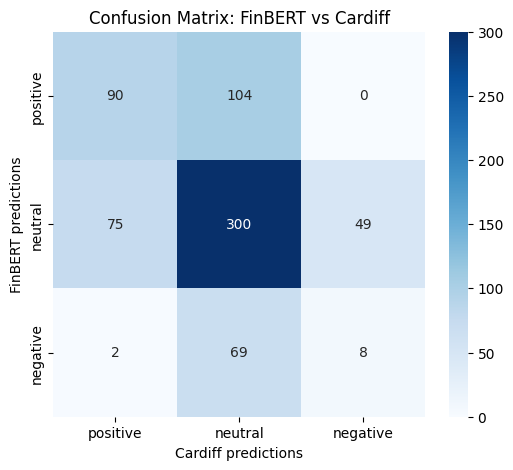

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix: rows = FinBERT, columns = Cardiff
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(comparison_df["finbert"], comparison_df["cardiff"], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Cardiff predictions")
plt.ylabel("DistilRoBERTa predictions")
plt.title("Confusion Matrix: DistilRoBERTa vs Cardiff")
plt.show()

### Disagreements Examples

Random sample of where models predicted different sentiments.

In [39]:
disagreements = comparison_df[~comparison_df["agreement"]].sample(10, random_state=SEED)
display(disagreements[["content", "finbert", "cardiff"]])

,content,finbert,cardiff
666,"So, yeah, you've noted all the points that we ...",positive,neutral
628,– that there's lots of different offsetting fa...,negative,neutral
376,"Yeah. And the particular nuance, as you'll rec...",negative,neutral
32,"Yeah, Betsy, we really don't have any new info...",positive,neutral
176,It's not true because if – can we not do that?,neutral,negative
659,"Yeah. Thanks, Glenn. So, I think the last part...",positive,neutral
231,Sure. The truth is – and I guess this is a goo...,positive,neutral
259,"If anyone has a different opinion, we're alway...",neutral,positive
20,"Can I just add also, housing is in short suppl...",negative,neutral
394,Can I just add a management thing that I think...,neutral,negative


## Detailed Analysis: DistilRoBERTa vs Cardiff (JPM Data)

### Model Behavior Differences

- **DistilRoBERTa** is a domain-specific model fine-tuned on financial news, which tends to produce more *polarized* sentiment predictions. It is more likely to assign `positive` or `negative` labels even for subtle tone shifts.
- **CardiffNLP (Twitter-RoBERTa)** is trained on social media data, where sentiment is often vague or indirect. As a result, it tends to default to `neutral` in ambiguous or nuanced cases.

🔍 In practice, DistilRoBERTa assigns more emotionally charged labels, especially favoring `positive` and `negative`, while Cardiff leans toward conservative, `neutral` assessments.

---

### Model Agreement: 57.1%

- Only **57.1%** of predictions agree across models — meaning nearly half of the outputs differ.
- Disagreements primarily occur between:
  - `positive` (DistilRoBERTa) vs `neutral` (Cardiff)
  - `neutral` (DistilRoBERTa) vs `negative` (Cardiff)

These indicate that the two models interpret borderline or soft statements differently, and could affect downstream aggregation and interpretation.

---

### Confusion Matrix Insights

- The most frequent mismatch is when DistilRoBERTa predicts `positive` while Cardiff predicts `neutral`.
- This highlights how DistilRoBERTa is more sensitive to implied optimism, whereas Cardiff filters out emotional bias more aggressively.

🧠 **Implication for the Project:**
- If your use case requires **interpretability** and **consistency** (e.g., PRA sentiment aggregation, summarization, or flagging risks), this disagreement needs to be addressed.
- You will likely need to either:
  - Perform **manual validation** on a sample to calibrate labels,
  - Or select one model to standardize on — e.g., DistilRoBERTa for its financial orientation.

---

## Next Steps (Without Manual Annotation Yet)

### Compare confidence strength

- 📉 Plot distribution of **confidence scores** (`sentiment_score`) for both models.
- This helps identify if models are "guessing" around 0.5 or are confidently polarized.

### Analyze confidence agreement

- 📊 Plot a **scatterplot of DistilRoBERTa vs Cardiff confidence scores**.
- This shows where one model is confident and the other is uncertain — often a red flag for disagreement.

### Create a `model_agreement` flag

- Add a column indicating where the models disagree.
- Use it to filter out high-uncertainty cases or explore them further.

---

## Recommendation

- Continue with both models in parallel to compare thematic distributions.
- Use disagreements to your advantage — they may highlight nuanced or controversial statements.
- Consider DistilRoBERTa as primary if financial tone polarity is important.

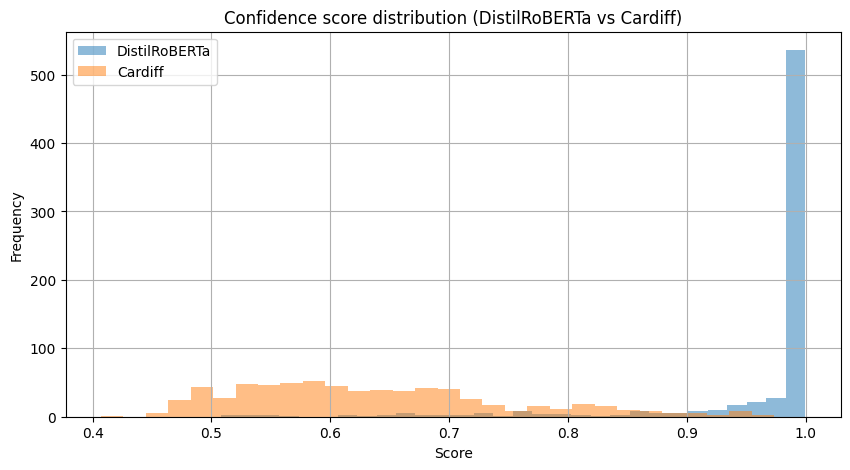

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
jpm_answers_df['sentiment_finbert_score'].hist(alpha=0.5, bins=30, label='DistilRoBERTa')
jpm_answers_df['sentiment_cardiff_score'].hist(alpha=0.5, bins=30, label='Cardiff')
plt.legend()
plt.title("Confidence score distribution (DistilRoBERTa vs Cardiff)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

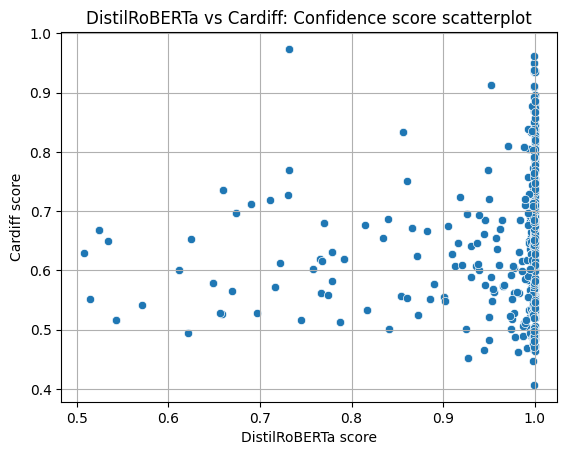

In [58]:
import seaborn as sns

scatter_df = jpm_answers_df[['sentiment_finbert_score']].copy()
scatter_df['cardiff_score'] = jpm_answers_df['sentiment_cardiff_score']
sns.scatterplot(data=scatter_df, x='sentiment_finbert_score', y='cardiff_score')
plt.title("DistilRoBERTa vs Cardiff: Confidence score scatterplot")
plt.xlabel("DistilRoBERTa score")
plt.ylabel("Cardiff score")
plt.grid(True)
plt.show()

### Distribution of Confidence Scores
The histogram reveals a clear contrast in how confident each model is when making predictions:

- **DistilRoBERTa** shows extremely high confidence, with the vast majority of predictions having scores close to **1.0**. This suggests that DistilRoBERTa tends to make **strong, decisive classifications**, even when the sentiment might be subtle.
- **Cardiff (Twitter-RoBERTa)** exhibits a **much flatter distribution**, with most scores spread between **0.5 and 0.75**. This implies more **conservative confidence** and hesitation in assigning extreme sentiment labels.

Such differences stem from **training domain and objective**:
- DistilRoBERTais tuned on financial news and thus calibrated for sharper tone detection.
- Cardiff is trained on Twitter data, which is noisier and more casual, so it leans toward neutral predictions when uncertain.

### Scatterplot of Confidence Agreement
The scatterplot of confidence scores between the two models shows that:
- **DistilRoBERTamaintains high confidence across all samples**, while
- **Cardiff's scores vary significantly**, even when DistilRoBERTais sure.
- There are many points with **high DistilRoBERTascore and mid-low Cardiff score**, especially around sentiment disagreements.

This reinforces the idea that **DistilRoBERTais more decisive**, while **Cardiff is cautious** — a key insight for downstream analysis.


## 6. Compare DistilRoBERTaand Cardiff Sentiment Models (HSBC)

In this section, we compare sentiment predictions for HSBC banker responses using two different models: DistilRoBERTaand Cardiff.

We will:
- Compare label distributions
- Calculate agreement rate
- Plot a confusion matrix
- Display disagreement examples

In [50]:
# --- 6.1.1 Prepare comparison dataframe for HSBC ---
hsbc_comparison_df = pd.DataFrame({
    "content": hsbc_answers_df["content"],
    "DistilRoBERTa": hsbc_answers_df["sentiment_finbert_label"],
    "cardiff": hsbc_answers_df["sentiment_cardiff_label"]
})

# Flag agreement
hsbc_comparison_df["agreement"] = hsbc_comparison_df["finbert"] == hsbc_comparison_df["cardiff"]

# Preview
hsbc_comparison_df.head()

,content,finbert,cardiff,agreement
0,Just one additional comment from me . You’ll n...,neutral,neutral,True
1,"Thanks, Manus. Just on the asset quality of S...",positive,positive,True
2,"Getting into some of the maths, we acquired a ...",neutral,neutral,True
3,At the end of 2022 the rate sensitivity on the...,positive,neutral,False
4,I’ll deal with the second one later. I’ll as ...,neutral,neutral,True


In [51]:
# --- 6.1.2 Sentiment Distribution ---
hsbc_finbert_counts = hsbc_comparison_df["finbert"].value_counts()
hsbc_cardiff_counts = hsbc_comparison_df["cardiff"].value_counts()

hsbc_dist_df = pd.DataFrame({
    "DistilRoBERTa": hsbc_finbert_counts,
    "Cardiff": hsbc_cardiff_counts
}).fillna(0).astype(int)

display(hsbc_dist_df)

,FinBERT,Cardiff
negative,8,0
neutral,52,103
positive,86,43


In [52]:
# --- 6.1.3 Agreement rate ---
hsbc_agreement_rate = hsbc_comparison_df["agreement"].mean()
print(f"🤝 Agreement between models (HSBC): {hsbc_agreement_rate:.2%}")

🤝 Agreement between models (HSBC): 60.27%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


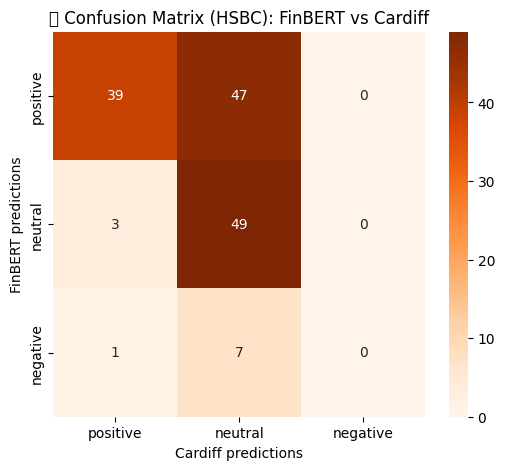

In [53]:
# --- 6.1.4 Confusion matrix ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["positive", "neutral", "negative"]
hsbc_cm = confusion_matrix(hsbc_comparison_df["finbert"], hsbc_comparison_df["cardiff"], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(hsbc_cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Oranges")
plt.xlabel("Cardiff predictions")
plt.ylabel("DistilRoBERTapredictions")
plt.title("Confusion Matrix (HSBC): DistilRoBERTa vs Cardiff")
plt.show()

In [54]:
# --- 6.1.5 Show disagreement examples ---
hsbc_disagreements = hsbc_comparison_df[~hsbc_comparison_df["agreement"]].sample(10, random_state=SEED)
display(hsbc_disagreements[["content", "finbert", "cardiff"]])

,content,finbert,cardiff
3,At the end of 2022 the rate sensitivity on the...,positive,neutral
17,"So Aman, if I can unpack the non -NII, some of...",positive,neutral
71,"Aman, what, historically, we have been giving ...",positive,neutral
28,"Yes, maybe just finishing on the ECL point, I ...",positive,neutral
108,"On your CRE question, Ed, of the $1.1 billion ...",positive,neutral
124,Morning. If I could have a couple on the orga...,positive,neutral
75,"I’ll start with your first question, Raul. Fi...",positive,neutral
55,"Just a quick one, firstly – you’ve reiterated...",positive,neutral
111,"I’m happy to take the question, thank you. You...",negative,positive
27,I think I’ll take the second one first and the...,positive,neutral


## Detailed Analysis: DistilRoBERTa vs Cardiff (HSBC Data)

### Key Findings:

1. **Model Behavior Differences**
   - **DistilRoBERTa** (trained on financial news) classifies more responses as *positive* or *negative*, leaning toward stronger sentiment.
   - **Cardiff NLP** (trained on tweets) heavily prefers *neutral* responses, especially when sentiment is ambiguous.
   - This leads to **disagreements**, especially when DistilRoBERTa labels a response as *positive*, but Cardiff calls it *neutral*.

2. **Disagreement Rate**
   - **Agreement between models** is only **60.27%**, meaning that almost **4 in 10** sentiment predictions differ between the models.
   - This is a moderate discrepancy and should not be ignored if sentiment is used in downstream tasks.

3. **Confusion Matrix Observations**
   - DistilRoBERTa predicted **86 positive** vs Cardiff's **43**.
   - DistilRoBERTa predicted **8 negative** vs Cardiff's **0**.
   - **Most disagreements** are clustered in:
     - DistilRoBERTa = *positive*, Cardiff = *neutral*
     - DistilRoBERTa = *negative*, Cardiff = *neutral*
   - Cardiff **avoids negative sentiment entirely** in HSBC outputs, suggesting possible underfitting or domain mismatch.

4. **Practical Implications**
   - Since sentiment is used for regulatory themes (e.g., PRA categorization), **model choice directly affects interpretation**.
   - Using Cardiff alone may **understate risks** or miss key tonal shifts in management discourse.
   - DistilRoBERTa, while more sensitive, might **over-emphasize** sentiment in vague statements.
